In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Initial Data Exploration

In [7]:
#What are the variables in the Boston Housing dataset?
Boston = pd.read_csv("Boston.csv")
Boston.columns

Index(['Unnamed: 0', 'crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis',
       'rad', 'tax', 'ptratio', 'black', 'lstat', 'medv'],
      dtype='object')

In [8]:
#How many observations and variables are there in this dataset?
Boston.shape

(506, 15)

### Below is a description of each of the variables

crim : per capita crime rate by town.

zn : proportion of residential land zoned for lots over 25,000 sq.ft.

indus : proportion of non-retail business acres per town.

chas : Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).

nox : nitrogen oxides concentration (parts per 10 million).

rm : average number of rooms per dwelling.

age : proportion of owner-occupied units built prior to 1940.

dis : weighted mean of distances to five Boston employment centres.

rad : index of accessibility to radial highways.

tax : full-value property-tax rate per \$10,000.

ptratio : pupil-teacher ratio by town.

black : 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town.

lstat : lower status of the population (percent).

medv : median value of owner-occupied homes in \$1000s.

### Do any of the variables have obvious outliers or strong skew?

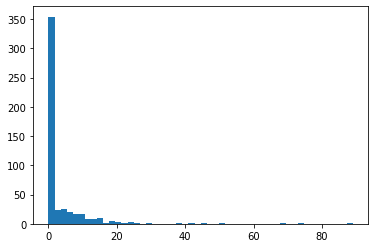

In [9]:
plt.hist(Boston.crim.values, bins=50)
plt.show()

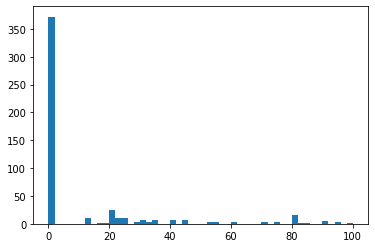

In [10]:
plt.hist(Boston.zn.values, bins=50)
plt.show()

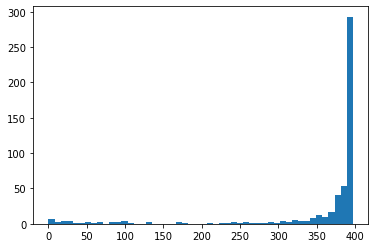

In [11]:
plt.hist(Boston.black.values, bins=50)
plt.show()

It looks like crim, zn, and black are all strongly skewed, while all other variables do not appear to have any obvious outliers or extreme skew (check for yourself though).

For these three variables, we will transform them using the logarithm, remove the original version from the dataframe, and add in the transformed variables with the same name.

In [12]:
Boston["crim"] = np.log(1 + Boston.crim.values)
Boston["zn"] = np.log(1 + Boston.zn.values)
Boston["black"] = np.log(400 - Boston.black.values)

# Model Selection

Here we wish to model the median value of homes (medv) as a function of all other variables. Furthermore, we want to find the simplest model that has the fewest number of variables in it.

To compare models we will use Mallow's $C_{p}$ defined as follows:

$$C_{p} = \dfrac{1}{n} \left( RSS + 2 p \hat{\sigma}^{2} \right)$$

where $RSS$ is the residual sum of squares, $p$ is the number of fit parameters, and $\hat{\sigma}$ is an estimate of the standard deviation of the noise. Here we will use $\hat{\sigma}^{2} = \dfrac{\sum\limits_{i=1}^{n} \left( Y_{i} - \hat{Y}_{i} \right)^{2}}{n - p}$.

### Forward Stepwise Selection

In [13]:
variables = Boston.columns.drop(["medv"])
modelvars = []
nullmdl = sm.OLS(Boston["medv"], sm.add_constant(Boston[modelvars])).fit()
rss = np.sum((Boston.medv.values - nullmdl.fittedvalues)**2)
cp = (rss + 2*(len(modelvars)+1)*rss/(len(Boston.medv.values) - (len(modelvars)+1)))/len(Boston.medv.values)
decreasing = True
while decreasing:
    cps = []
    for var in variables:
        mdl = sm.OLS(Boston["medv"], sm.add_constant(Boston[modelvars + [var]])).fit()
        rss = np.sum((Boston.medv.values - mdl.fittedvalues)**2)
        cps.append((rss + 2*(len(modelvars)+2)*rss/(len(Boston.medv.values) - (len(modelvars)+2)))/len(Boston.medv.values))
    best = np.argmin(cps)
    if cps[best] < cp:
        modelvars.append(variables[best])
        variables.drop([variables[best]])
        cp = cps[best]
    else:
        decreasing = False

C:\Users\kavan\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [14]:
#Which variables were selected as the best for this linear model through forward selection
modelvars

['lstat', 'rm', 'ptratio', 'dis', 'nox', 'chas', 'zn']

In [15]:
#What does the final model look like
finalmdl = sm.OLS(Boston["medv"], sm.add_constant(Boston[modelvars])).fit()
finalmdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     181.5
Date:                Sat, 21 Sep 2019   Prob (F-statistic):          1.23e-132
Time:                        13:22:46   Log-Likelihood:                -1519.7
No. Observations:                 506   AIC:                             3055.
Df Residuals:                     498   BIC:                             3089.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.5391      4.546      8.037      0.000      27.607      45.471
lstat         -0.5776      0.047    -12.180      0.000      -0.671      -0.484
rm             3.9567      0.412      9.599      0.000       3.147       4.767
ptratio       -0.9063      0.121     -7.488      0.000      -1.144      -0.669
dis           -1.3580      0.194     -7.009      0.000      -1.739      -0.977
nox          -18.6435      3.216     -5.797      0.000     -24.962     -12.325
chas           3.3105      0.881      3.759      0.000       1.580       5.041
zn             0.4485      0.210      2.140      0.033       0.037       0.860
==============================================================================
Omnibus:                      166.913   Durbin-Watson:                   1.062
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              694.132
Skew:                           1.436   Prob(JB):                    1.87e-151
Kurtosis:                       7.968   Cond. No.                         546.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Backward Stepwise Selection

In [16]:
modelvars2 = Boston.columns.drop(["medv"])
fullmdl = sm.OLS(Boston["medv"], sm.add_constant(Boston[modelvars2])).fit()
rss = np.sum((Boston.medv.values - fullmdl.fittedvalues)**2)
cp = (rss + 2*(len(modelvars2)+1)*rss/(len(Boston.medv.values) - (len(modelvars2)+1)))/len(Boston.medv.values)
decreasing = True
while decreasing:
    cps = []
    for var in modelvars2:
        tempmodelvars2 = list(modelvars2)
        tempmodelvars2.remove(var)
        mdl = sm.OLS(Boston["medv"], sm.add_constant(Boston[tempmodelvars2])).fit()
        rss = np.sum((Boston.medv.values - mdl.fittedvalues)**2)
        cps.append((rss + 2*(len(tempmodelvars2)+1)*rss/(len(Boston.medv.values) - (len(tempmodelvars2)+1)))/len(Boston.medv.values))
    best = np.argmin(cps)
    if cps[best] < cp:
        modelvars2 = modelvars2.drop(modelvars2[best])
        cp = cps[best]
    else:
        decreasing = False

In [17]:
#What variables were selected by now using backward selection?
modelvars2

Index(['crim', 'zn', 'chas', 'nox', 'rm', 'dis', 'rad', 'tax', 'ptratio',
       'lstat'],
      dtype='object')

In [18]:
#What does the new final model look like?
finalmdl2 = sm.OLS(Boston["medv"], sm.add_constant(Boston[modelvars2])).fit()
finalmdl2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     131.3
Date:                Sat, 21 Sep 2019   Prob (F-statistic):          2.67e-132
Time:                        13:23:34   Log-Likelihood:                -1512.5
No. Observations:                 506   AIC:                             3047.
Df Residuals:                     495   BIC:                             3094.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.9833      5.007      7.986      0.000      30.146      49.820
crim          -1.1304      0.598     -1.892      0.059      -2.305       0.044
zn             0.4379      0.212      2.065      0.039       0.021       0.854
chas           2.9796      0.876      3.400      0.001       1.258       4.701
nox          -16.6063      3.665     -4.531      0.000     -23.807      -9.405
rm             3.7499      0.415      9.036      0.000       2.935       4.565
dis           -1.3911      0.193     -7.210      0.000      -1.770      -1.012
rad            0.2912      0.080      3.621      0.000       0.133       0.449
tax           -0.0102      0.003     -2.989      0.003      -0.017      -0.003
ptratio       -0.9678      0.138     -7.027      0.000      -1.238      -0.697
lstat         -0.5537      0.049    -11.226      0.000      -0.651      -0.457
==============================================================================
Omnibus:                      174.200   Durbin-Watson:                   1.046
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              735.625
Skew:                           1.500   Prob(JB):                    1.82e-160
Kurtosis:                       8.089   Cond. No.                     1.14e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.14e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""